**TODO**:
- fix pyspice to do not only R sweeps but also other parameter sweeps. The issue appears to be in the `plot` module that read the return from ngspice server results.
    - need to experiment with ngspice server, since I have already confirmed R sweep just using ngspice alone
    - run simulation from pyspice step by step and grab results without `plot`
    - fix `plot`
    
- use what we have done
- find max power and efficincy with the SPICE
- add usage of standard resistor values from sweep 

In [1]:
#Library import statements

from skidl.pyspice import *
#can you say cheeky 
import PySpice as pspice
#becouse it's written by a kiwi you know
import lcapy as kiwi

import sympy as sym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from IPython.display import YouTubeVideo, display

import traceback

#notebook specific loading control statements 
%matplotlib inline
#tool to log notebook internals
#https://github.com/jrjohansson/version_information
%load_ext version_information
%version_information skidl, PySpice,lcapy, sympy, numpy, matplotlib, pandas, scipy

# Maximum Power Transfer Theorem

The Maximum Power transfer theorem for DC states that when the Load is equal to the Thevenin resistance of the circuit($R_{L}=R_{th}$) the power delivered to the load is maximized which is proven via taking the derivative of $$P=i^2 R_L=(\dfrac{V_{th}}{R_{th}+R_L})^2 R_L$$ and setting it to zero and solving. The details of which are given by ALL ABOUT ELECTRONICS in his YT video [Maximum Power Transfer Theorem for DC Circuits (with Examples)](https://www.youtube.com/watch?v=RbII8o49Hvs). But suffice to say we have already done the work to find this in the last two sections of this chapter by finding the Thevenin and Norton values of the circuit or when permitted using the .tf to find the DC transfer function which also gives us the input resistance. But here we want to show how to just sweep the load resistance itself (or any resistor in the circuit) and then find the peak in the resulting data that will give us the maximum power while also measuring the efficiency of the load where then we can find the ideal optimal load by finding the intersection of the two curves. We can do this by again utilizing the machinery we have developed to easily find the Thevenin and Norton equivalent circuits for circuits with multiple sources. Further, we want to then translate that semi-arbitrary value to a value we can use in the real world where the values you can get for a resistor are finite. So, let’s start with a theoretical model and then work with Examples 2 and 3 from ALL ABOUT ELECTRONICS video and develop a tool to automatically do all this for us.


## Max Power Delivered vs Most Efficient Power Delivered

In [2]:
efficiency, powerload, powersource, current, voltage, Rth, RL =sym.symbols(r"\eta, P_L, P_S, i, v, R_{th}, R_L")
efficiency, powerload, powersource, current, voltage, Rth, RL

For a DC Thevenin reduced circuit (one that contains only a Thevenin voltage source, Thevenin equivalent resistor, and equivalent load resistor) we know that the current will be

In [3]:
ithev_eq=sym.Eq(current, voltage/(Rth+RL)); ithev_eq

and the power in the load will be 

In [4]:
powerload_eq=sym.Eq(powerload, current**2 * RL); powerload_eq

and thus the power the load receives reduces to

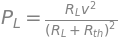

In [5]:
powerload_eq=powerload_eq.subs({ithev_eq.lhs: ithev_eq.rhs}); powerload_eq

Using the first example from [Maximum Power Transfer Theorem for DC Circuits (with Examples)](https://www.youtube.com/watch?v=RbII8o49Hvs) we know and can find the Thevenin equivalent easily, and thus the max power that the source can supply. And so if we then plot the values of the power of the load vs the resistance of the load we get

In [6]:
subs={Rth:8,  voltage:32}

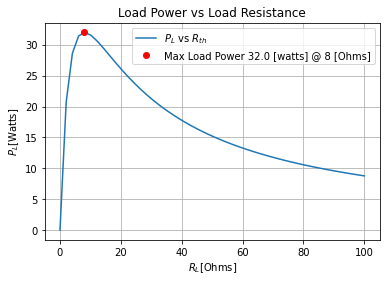

In [7]:
powerload_lam=sym.lambdify(RL, powerload_eq.rhs.subs(subs))

RL_sweep=np.linspace(0, 100)
plt.plot(RL_sweep, powerload_lam(RL_sweep), label=f'${powerload}$ vs ${Rth}$')
plt.plot(8, powerload_lam(subs[Rth]), 'ro', label=f'Max Load Power {powerload_lam(subs[Rth])} [watts] @ {subs[Rth]} [Ohms]')
plt.xlabel(f"${RL}$[Ohms]"); plt.ylabel(f"${powerload}$[Watts]")
plt.legend()
plt.grid()
plt.title('Load Power vs Load Resistance');

But this is not our efficient load since our Thevenin equivalent source of the voltage and current source given by this example can deliver a total power of 128 [watts] when the load is short-circuited. So, then what is the most efficient load. While efficiency is defined as. Where we are looking at the global sources and global loads to our circuit which we have made easy in this example by looking only at a Thevenin reduced DC circuit

In [8]:
efficiency_eq=sym.Eq(efficiency, powerload/powersource); efficiency_eq

the power from the source with a completed Thevenin circuit with load is the sum of the power in the Thevenin and load resistances

In [9]:
powersource_eq=sym.Eq(powersource, current**2 *Rth +current**2 *RL); powersource_eq

Substituting the expression for the current in the Thevenin circuit we have

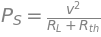

In [10]:
powersource_eq=sym.simplify(powersource_eq.subs({ithev_eq.lhs: ithev_eq.rhs})); powersource_eq

plotting this as a function of the load we can see how the load affects the power supplied on the Thevenin equivalent source

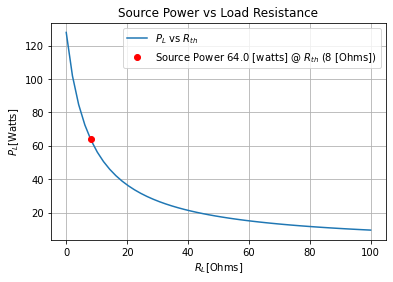

In [11]:
powersource_lam=sym.lambdify(RL, powersource_eq.rhs.subs(subs))

plt.plot(RL_sweep, powersource_lam(RL_sweep), label=f'${powerload}$ vs ${Rth}$')
plt.plot(8, powersource_lam(subs[Rth]), 'ro', label=f'Source Power {powersource_lam(subs[Rth])} [watts] @ ${Rth}$ ({subs[Rth]} [Ohms])')
plt.xlabel(f"${RL}$[Ohms]"); plt.ylabel(f"${powerload}$[Watts]")
plt.legend()
plt.grid()
plt.title('Source Power vs Load Resistance');

so then we find for the case of a DC Thevenin circuit our efficiency is

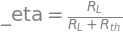

In [12]:
efficiency_eq=efficiency_eq.subs({powersource_eq.lhs:powersource_eq.rhs, powerload_eq.lhs:powerload_eq.rhs  }); efficiency_eq

So then we can compare the efficiency (which is only defined between 0 and 1) to the power transferred to the load normalized to the maximum power at the Thevenin resistance as follows

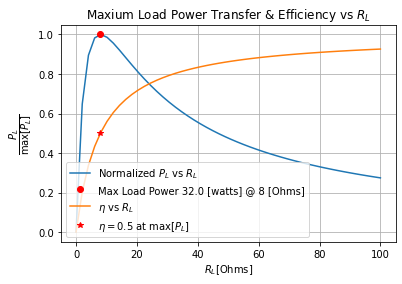

In [13]:
powerload_norm_lam=sym.lambdify(RL, powerload_eq.rhs.subs(subs)/powerload_eq.rhs.subs(subs).subs({RL:subs[Rth]}))

efficiency_lam=sym.lambdify(RL, efficiency_eq.rhs.subs(subs))


plt.plot(RL_sweep, powerload_norm_lam(RL_sweep), label=f'Normalized ${powerload}$ vs ${RL}$')
plt.plot(subs[Rth], powerload_norm_lam(subs[Rth]), 'ro', label=f'Max Load Power {powerload_lam(subs[Rth])} [watts] @ {subs[Rth]} [Ohms]')

plt.plot(RL_sweep, efficiency_lam(RL_sweep), label=f'${efficiency}$ vs ${RL}$')

plt.plot(subs[Rth], efficiency_lam(subs[Rth]), 'r*', 
         label=f'${efficiency}={efficiency_lam(subs[Rth])}$ at $\max[{powerload}]$')


plt.xlabel(f"${RL}$[Ohms]"); 
plt.ylabel(r'$\dfrac{'+f"{powerload}"+'}{\max['+f"{powerload}"+"]}$")

plt.legend()
plt.grid()
plt.title(f'Maxium Load Power Transfer & Efficiency vs ${RL}$');

So then if we need to optimize the DC maximum power to the load, we know it to be the load resistance equal the Thevenin resistance; but if we could sacrifice the maximum power to the load in order max out the efficiency of our total circuit while minimizing the loss of power delivered to load. We then can then find said load via the intersection of the two curves above thusly

In [14]:
#%%writefile -a DC_1_Codes.py
#chapter 1 section 6 findIntersection function
#Assist function to find the intersection of two functions

#from https://glowingpython.blogspot.com/2011/05/hot-to-find-intersection-of-two.html 
#load fslove from scipy's optimize module
from scipy.optimize import fsolve

#helper function to find the intersection of two functions with an initial guess
def findIntersection(fun1,fun2,x0):
    """
    Aid function to find the intersection point of two curves
    from: https://glowingpython.blogspot.com/2011/05/hot-to-find-intersection-of-two.html 
    
    Args:
        func1(function or class): the first function whose curve is 
            used to find the intersection of the two curves
        
        func2(function or class): the second function whose curve is 
            used to find the intersection of the two curves
        
        x0 (float); initial guess of the intersection of the two functions
    
    Returns:
        Returns array of float that are the intersections of the two functions, 
        this is not very robust and thus one should read `fsolve`'s documentation 
        for caveats  of usage
    """
    return fsolve(lambda x : fun1(x) - fun2(x),x0)

In [15]:
#find the find the intersection and round value to three digits and; get just the first intersection
optimal_point=np.around(findIntersection(powerload_norm_lam, efficiency_lam, subs[Rth]), 3)[0]
optimal_point

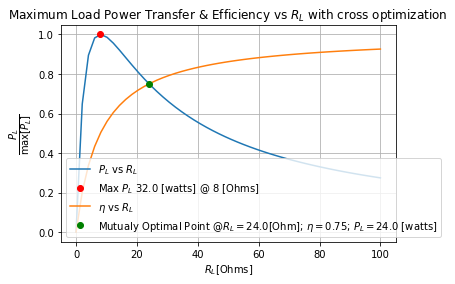

In [16]:
plt.plot(RL_sweep, powerload_norm_lam(RL_sweep), label=f'${powerload}$ vs ${RL}$')
plt.plot(subs[Rth], powerload_norm_lam(subs[Rth]), 'ro', label=f'Max ${powerload}$ {powerload_lam(subs[Rth])} [watts] @ {subs[Rth]} [Ohms]')

plt.plot(RL_sweep, efficiency_lam(RL_sweep), label=f'${efficiency}$ vs ${RL}$')
plt.plot(optimal_point, efficiency_lam(optimal_point), 'go', 
         label=f'Mutualy Optimal Point @${RL}={optimal_point}$[Ohm]; ${efficiency}={efficiency_lam(optimal_point)}$; ${powerload}={powerload_lam(optimal_point)}$ [watts]')

plt.xlabel(f"${RL}$[Ohms]")
plt.ylabel(r'$\dfrac{'+f"{powerload}"+'}{\max['+f"{powerload}"+"]}$")

plt.legend()
plt.grid()
plt.title(f'Maximum Load Power Transfer & Efficiency vs ${RL}$ with cross optimization');

Thus, by moving to the intersection of the Power to the load and the efficiency of the circuit at the load from the Maximum power to the load point. We have a reduction of the amount of power delivered to the load of

In [17]:
powerload_at_mpow=powerload_lam(subs[Rth])
powerload_at_mp=powerload_lam(optimal_point)
f"{powerload_at_mpow}[watts] to {powerload_at_mp}[watts]; a {powerload_at_mp-powerload_at_mpow}[watt] change"

'32.0[watts] to 24.0[watts]; a -8.0[watt] change'

And have gained an efficiency boost of

In [18]:
efficiency_at_mpow=efficiency_lam(subs[Rth])
efficiency_at_mp=efficiency_lam(optimal_point)
f"{efficiency_at_mpow*100}% to {efficiency_at_mp*100}%; a {(efficiency_at_mp-efficiency_at_mpow)*100}% gain"

'50.0% to 75.0%; a 25.0% gain'

So now the task at hand is to move beyond this ideal theoretical example to having SPICE find the values we need and then building a testbench class in python that will do the data analysis along with all the SPICE work we just showed automatically for nearly any DC circuit. Where AC circuits and circuits that rely on Transient circuit effects (think switch-mode power supplies) will have to be analyzed separately when we cross those bridges.

## Cannot move on due to the issue in pyspice that prevents sweeping anything but Current and Voltage Sources; see TODO above

## Example 2 from "Maximum Power Transfer Theorem for DC Circuits (with Examples)" @ ~4:47 min 

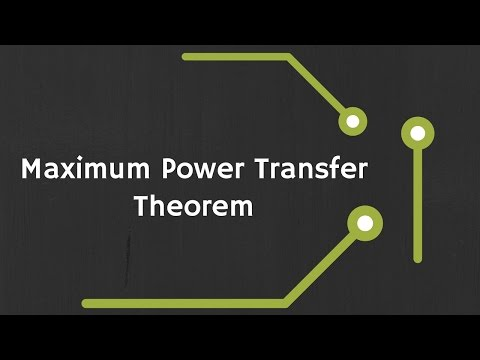

In [19]:
YouTubeVideo('RbII8o49Hvs', width=500, height=400, start=287)

In [20]:
reset()
net_1=Net('N1'); net_2=Net('N2'); net_3=Net('N3'); net_4=Net('N4')

#voltage source bottom left
vs=V(dc_value=100@u_V); vs['p', 'n']+=net_1, gnd
#restors on the center leg
rleft=R(ref='left', value=4@u_Ohm); rleft[1, 2]+=net_1, net_2
rright=R(ref='right', value=4@u_Ohm); rright[1, 2]+=net_2, net_3

#vcvs and resistor on top leg
vcvs=E(voltage_gain=1)
#vcvs inputs; outputs
vcvs['ip', 'in']+=net_2, net_1; vcvs['op', 'on']+=net_1, net_4
rtop=R(ref='top', value=4@u_Ohm); rtop[1, 2]+=net_4, net_3

#load with dummy resistance
rload=R(ref='load', value=1@u_Ohm); rload[1, 2]+=net_3, gnd


circ=generate_netlist()
print(circ)

.title 
E1 N1 N4 N2 N1 1
V1 N1 0 100V
Rleft N1 N2 4Ohm
Rload N3 0 1Ohm
Rright N2 N3 4Ohm
Rtop N4 N3 4Ohm




No errors or warnings found during netlist generation.



## Example 3 from "Maximum Power Transfer Theorem for DC Circuits (with Examples)" @ ~8:46 min 

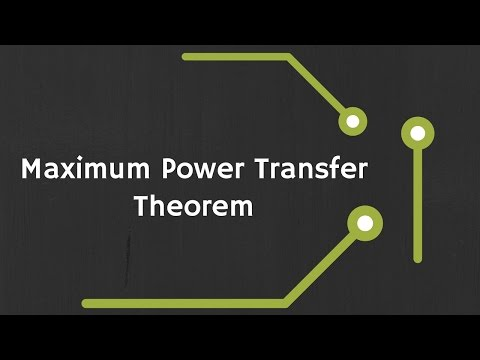

In [21]:
YouTubeVideo('RbII8o49Hvs', width=500, height=400, start=526)

In [22]:
reset()
net_1=Net('N1'); net_2=Net('N2'); net_3=Net('N3')

vs=V(dc_value=10@u_V); vs['p', 'n']+=net_1, gnd

#center T network
rleft=R(ref='left', value=30@u_Ohm); rleft[1, 2]+=net_1, net_2
rcenter=R(ref='center', value=30@u_Ohm); rcenter[1, 2]+=net_2, gnd
rright=R(ref='right', value=30@u_Ohm); rright[1, 2]+=net_2, net_3

#rvar with dummy resistance
rtest=R(ref='test', value=1@u_Ohm); rtest[1, 2]+=net_1, net_3

rload=R(ref='load', value=10@u_Ohm); rload[1, 2]+=net_3, gnd

circ=generate_netlist()
print(circ)

.title 
V1 N1 0 10V
Rcenter N2 0 30Ohm
Rleft N1 N2 30Ohm
Rload N3 0 10Ohm
Rright N2 N3 30Ohm
Rtest N1 N3 1Ohm




No errors or warnings found during netlist generation.



## Citations:
[1] ALL ABOUT ELECTRONICS. "Maximum Power Transfer Theorem for DC Circuits (with Examples)," YouTube, May 20, 2017. [Video file]. Available: https://youtu.be/RbII8o49Hvs. [Accessed: Nov 30, 2020].

[2] @JustGlowing, “How to find the intersection of two functions,” The Glowing Python, 10-May-2011. [Online]. Available: https://glowingpython.blogspot.com/2011/05/hot-to-find-intersection-of-two.html. [Accessed: 20-Nov-2020].